### Filling Factor
- **ν**: Filling factor 1/2
- **Nk**: Number of k-points must be multiple of denominator for commensurability
- **Ne = Nk * ν**: Number of electrons

### Key Physics
- **Ground state competition**: in n=0 Landau level, competition between pfaffin-related states and composite Fermi liquids; in n=1 Landau level, Moore-Read states are the ground states.

In [4]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level torus.jl")
using .LLT

# square/triangular lattice
sqa_lattice = ReciprocalLattice(:square);          # == ReciprocalLattice(1, 0)
tri_lattice = ReciprocalLattice(:triangular);      # == ReciprocalLattice(1, -1//2)
# general_lattice = ReciprocalLattice(abs(G2/G1), cos(θ))
# use exact values, Integer or Rational, to avoid uncertainty on Brillouin Zone boundary.

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(energies, ss_k1, ss_k2; 
    title = nothing, ylims = (nothing, nothing),
    ylabel = "Energy per unit cell (W₀ = e²/ϵl)",
)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = ylabel
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(ss_k1)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        if isassigned(energies,i)
            for e in energies[i]
                scatter!(ax, x, e, color = :blue, marker=:hline)
            end
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
    fig
end

function plot_entanglement_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1,1];
        xlabel = "Ne in A-part",
        xticksvisible = false,
        xgridvisible = false,
        xminorgridvisible = true,
    )

    x = 0
    NA_lines = Float64[-0.5;]
    xtickposition = Float64[];
    xticklabel = String[];
    for indexNA in CartesianIndices(entanglement_spectrum)
        x_begin = x
        for (indexkA, spectrum) in enumerate(entanglement_spectrum[indexNA])
            if !isempty(spectrum)
                for e in spectrum
                    scatter!(ax, x, e, color = :blue, marker=:hline)
                end
                x += 1
            end
        end
        x_end = x
        if x_end > x_begin
            NA = string(indexNA[1]-1)
            for i in 2:length(indexNA)
                NA *= ",$(indexNA[i]-1)"
            end
            push!(xtickposition, 0.5(x_begin+x_end-1))
            push!(xticklabel, NA)
            push!(NA_lines, x-0.5)
        end
    end
    ax.xticks = (xtickposition, xticklabel)
    ax.xminorticks = NA_lines
    if title isa String
        ax.subtitle = title
    end
    ylims!(ax, ylims...)
    display(fig)
    fig
end

plot_entanglement_spectrum (generic function with 1 method)

In [5]:
k_list = [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5;
          0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]

# System parameters
Nk = 24         # Total number of k-points
Gk = (6, 4)     # Grid dimensions (G1_direction, G2_direction)
Ne = 6          # Ne electrons for this system

6

In [6]:
# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(ReciprocalLattice(0.77, 0), (1, 2, 1, 0));

# show the pseudopotential decomposition of the gate-screened Coulomb interaction for reference
sys_int.D_l = 5.0                              # gate distance / magnetic length 
show( LLT.pseudo_potential_decomposition.(0:10; D_l = sys_int.D_l, d_l = 0.0) )
sys_int.V_intra = LLT.pseudo_potential_decomposition.(0:10; D_l = sys_int.D_l, d_l = 0.0)
# sys_int.V_intra[1:3] .= 0.0
sys_int.V_intra = [0.0; 1.0]

# use Haldane pseudopotential
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para = EDPara(k_list = k_list, Gk = Gk, 
    V_int = sys_int, FF_inf_angle = LLT.Landau_ff_inf(sys_int));

[1.501982636440383, 0.6221557340393984, 0.40664424293836865, 0.30158556536371806, 0.23776931630752113, 0.19444791767975755, 0.1629877940798242, 0.13908056457052326, 0.12030920054636296, 0.10520165028815111, 0.09280505933768239]

In [7]:
# Create momentum blocks (Hilbert subspace)
subspaces, ss_k1, ss_k2 = ED_momentum_subspaces(para, (Ne, ));
display(length.(subspaces))

# one-body terms are all zero in flat Landau level
scat = ED_sortedScatterList_twobody(para);

# construct the Hamiltonian operator
hmlt = MBOperator(scat; upper_hermitian = true)

24-element Vector{Int64}:
 5582
 5620
 5582
 5620
 5616
 5616
 5616
 5616
 5580
 5616
    ⋮
 5620
 5580
 5616
 5580
 5616
 5616
 5616
 5616
 5616

Many Body Operator (upper_hermitian=true) :
	Vector{EDCore.Scatter{2}} with 1734 scattering terms


In [8]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], hmlt;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 5582, momentum 0, 0
  0.477083 seconds (651.81 k allocations: 103.923 MiB, 149.63% compilation time)
  3.007740 seconds (5.64 M allocations: 370.389 MiB, 1.73% gc time, 102.94% compilation time)
Processing subspace #2 with size 5620, momentum 0, 1
  0.048717 seconds (603 allocations: 72.579 MiB, 17.63% gc time)
  0.372310 seconds (9.26 k allocations: 98.189 MiB, 4.49% gc time)
Processing subspace #3 with size 5582, momentum 0, 2
  0.045923 seconds (648 allocations: 72.008 MiB, 14.58% gc time)
  0.479592 seconds (9.95 k allocations: 105.303 MiB, 26.44% gc time)
Processing subspace #4 with size 5620, momentum 0, 3
  0.043799 seconds (601 allocations: 72.579 MiB, 12.99% gc time)
  0.356697 seconds (9.00 k allocations: 95.588 MiB, 2.59% gc time)
Processing subspace #5 with size 5616, momentum 1, 0
  0.047492 seconds (604 allocations: 72.493 MiB, 13.87% gc time)
  0.355416 seconds (9.58 k allocations: 101.061 MiB, 2.79% gc time)
Processing subspace #6 with s

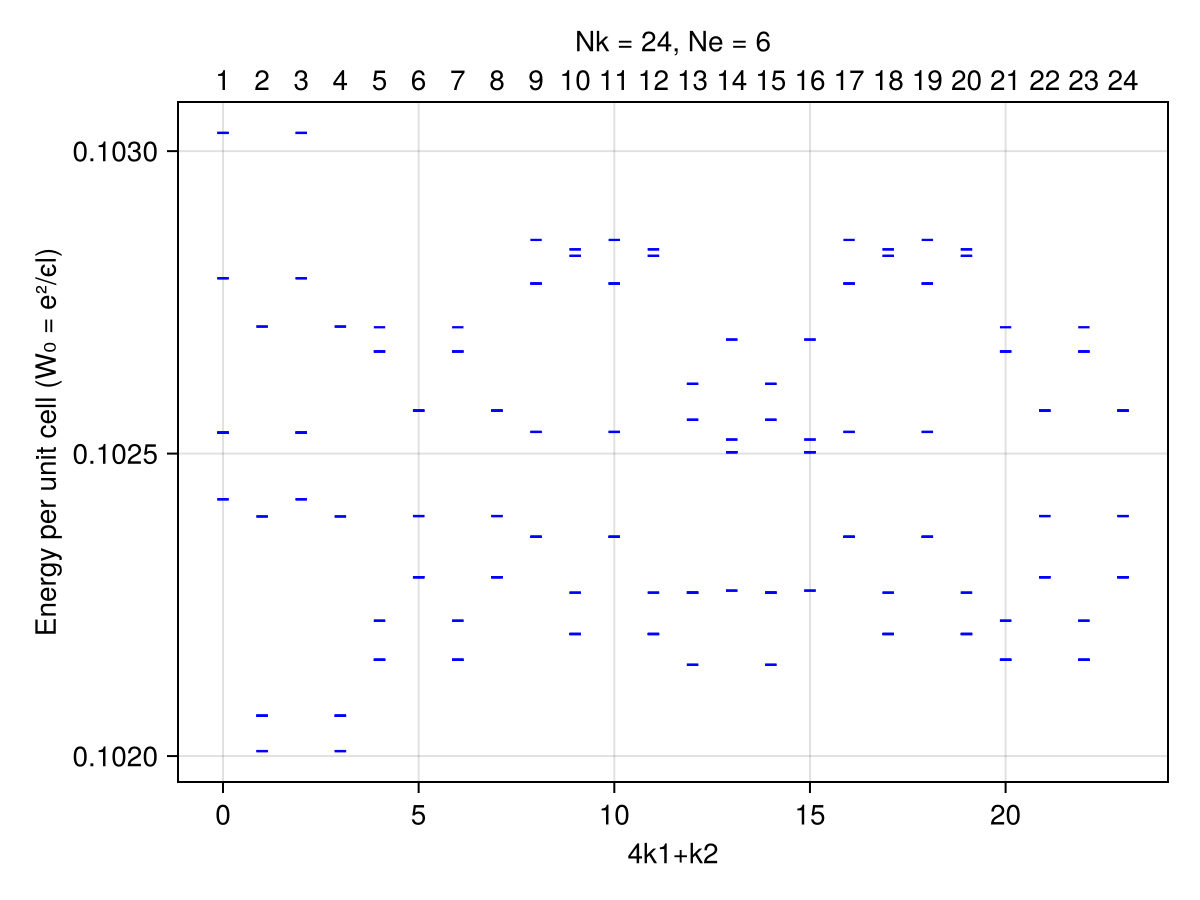

In [9]:
plot_ed_spectrum(energies/Nk/LLT.W0, ss_k1, ss_k2,
    title = "Nk = $Nk, Ne = $Ne",
);

In [10]:
# check energies explicitly to see degeneracy.

sn = 2 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  1


10-element Vector{Float64}:
 0.10200827257620469
 0.10200827257620541
 0.10206673088364815
 0.10206673088364832
 0.10206673088364898
 0.10206673088364919
 0.10239609745104646
 0.10239609745104733
 0.10270999007699544
 0.10270999007699559

Calculate the structure factor

In [11]:
NG = 2
index_shift = NG .* Gk .+ 1
densities = MBOperator[density_operator(q1, q2; 
        para = para, form_factor = false)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
];
function structure_factor_expectation(myvec)
    structure_factor = similar(densities, ComplexF64)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
        structure_factor[index_shift[1]+q1, index_shift[2]+q2] = 
            ED_bracket_threaded(myvec, 
                densities[index_shift[1]-q1, index_shift[2]-q2], 
                densities[index_shift[1]+q1, index_shift[2]+q2], myvec
            )
        if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0
            structure_factor[index_shift[1]+q1, index_shift[2]+q2] -= 
                ED_bracket_threaded(myvec, densities[index_shift[1]-q1, index_shift[2]-q2], myvec) * 
                ED_bracket_threaded(myvec, densities[index_shift[1]+q1, index_shift[2]+q2], myvec)
        end
    end
    structure_factor ./= Nk
end

structure_factor_expectation (generic function with 1 method)

In [12]:
@time str_fac = sum(snx -> structure_factor_expectation(vectors[snx[1]][snx[2]]), Iterators.product((2,4), (1,2)))/4;

  7.382422 seconds (1.92 M allocations: 95.460 MiB, 11.40% compilation time)


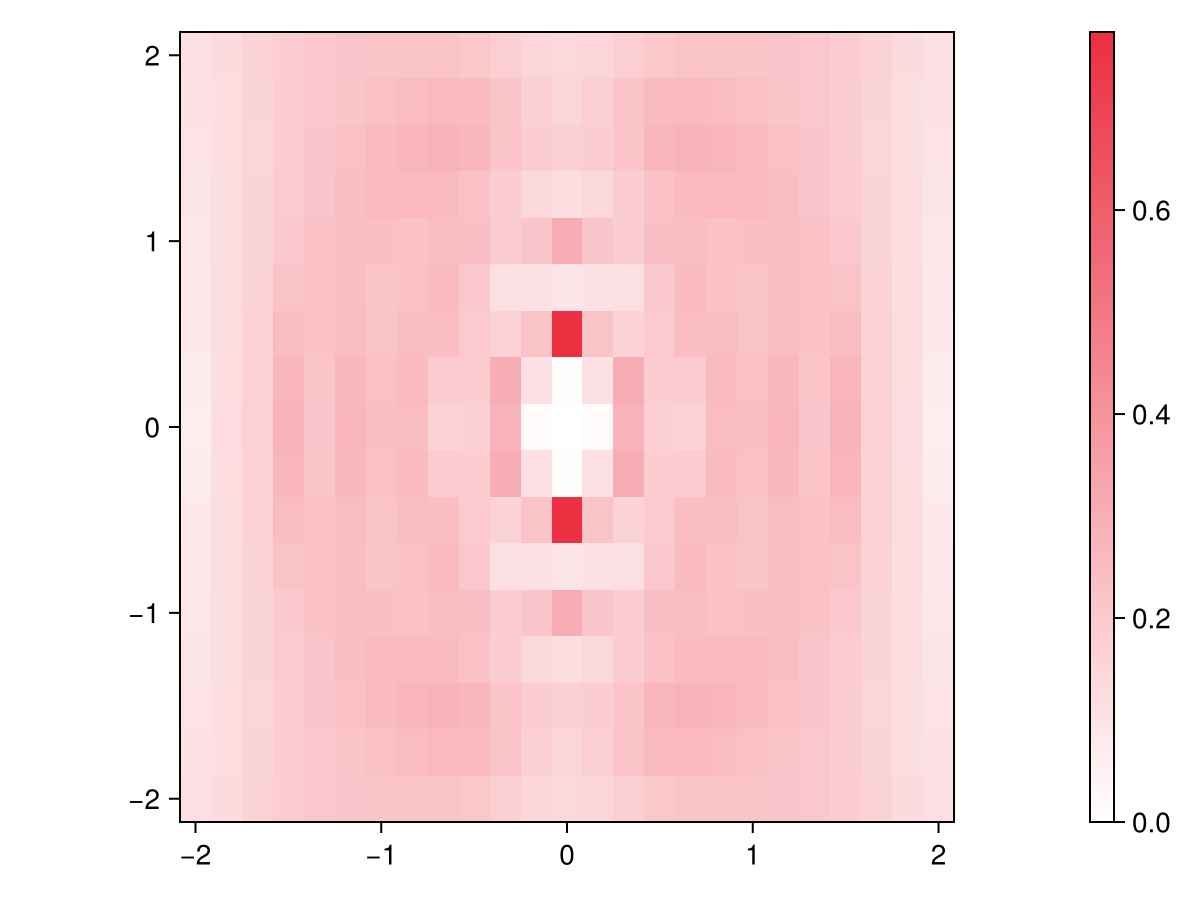

CairoMakie.Screen{IMAGE}


In [13]:
let structure_factor = str_fac
    fig = Figure();
    ax = Axis(fig[1,1]; aspect = DataAspect())
    hm = heatmap!(ax, (-NG*Gk[1]:NG*Gk[1])./Gk[1], (-NG*Gk[2]:NG*Gk[2])./Gk[2], 
        real.(structure_factor);
        colorrange = (0.0, maximum(real.(structure_factor))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end